# Setups

In [1]:
!pip install networkx[default]


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
with open('./data/data.txt', 'w') as f:
    f.write('''[2 1]
[3 1] [3 2]
[4 1] [4 2] [4 3]
[5 1]
[6 1]
[7 1] [7 5] [7 6]
[8 1] [8 2] [8 3] [8 4]
[9 1] [9 3]
[10 3]
[11 1] [11 5] [11 6]
[12 1]
[13 1] [13 4]
[14 1] [14 2] [14 3] [14 4]
[17 6] [17 7]
[18 1] [18 2]
[20 1] [20 2]
[22 1] [22 2]
[26 24] [26 25]
[28 3] [28 24] [28 25]
[29 3]
[30 24] [30 27]
[31 2] [31 9]
[32 1] [32 25] [32 26] [32 29]
[33 3] [33 9] [33 15] [33 16] [33 19] [33 21] [33 23] [33 24] [33 30] [33 31] [33 32]
[34 9] [34 10] [34 14] [34 15] [34 16] [34 19] [34 20] [34 21] [34 23] [34 24] [34 27] [34 28] [34 29] [34 30] [34 31] [34 32] [34 33]''')

# Imports

In [3]:
from typing import Optional
import networkx as nx
import re
from collections.abc import Callable
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

from read_edges import parse_graph_from_file, edge_regex, parse_match
from bfs import bfs
from dfs import dfs
from shortest_path import bfs as bfs_shortest_path
from all_paths import find_all_paths
from cycle_detection import dfs as dfs_cycle_detection
from node_degrees import get_degrees
from overlap_measures import jaccard, salton, sorenson
from laplacians import get_laplacian, get_sym_laplacian, get_rw_laplacian, get_matrix

# Parsing

## Edges

In [4]:
graph = parse_graph_from_file('./data/data.txt')

print(graph)

Graph with 34 nodes and 78 edges


## Matrix

### Convert to matrix file

In [5]:
with open("./data/data.txt", "r") as f:
    file_data = " ".join(f.readlines())

edges = [parse_match(match) for match in re.finditer(edge_regex, file_data)]

all_nodes = set([e[0] for e in edges] + [e[1] for e in edges])
n = len(all_nodes)

matrix = [[False] * n for _ in range(n)]

for edge in edges:
    matrix[edge[0] - 1][edge[1] - 1] = True
    matrix[edge[1] - 1][edge[0] - 1] = True

with open('./data/matrix.txt', 'w') as f:
    f.write(str(matrix))

### Read

In [6]:
with open("./data/matrix.txt", "r") as f:
    matrix = eval(f.readline())

graph = nx.Graph()

for i, row in enumerate(matrix, 1):
    connections = [(i, j) for j, elem in enumerate(row, 1) if elem]
    graph.add_edges_from(connections)

print(graph)

Graph with 34 nodes and 78 edges


# Algorithms

## BFS

In [7]:
bfs(1, graph, lambda x, _: print(x))

1
2
3
4
5
6
7
8
9
11
12
13
14
18
20
22
32
31
10
28
29
33
17
34
25
26
24
15
16
19
21
23
30
27


## DFS

In [8]:
dfs(1, graph, lambda x, _: print(x))

1
2
3
4
8
13
14
34
9
31
33
15
16
19
21
23
24
26
25
28
32
29
30
27
10
20
18
22
5
7
6
11
17
12


## Shortest path

In [9]:
src = 17
dest = 19

dist, parent = bfs_shortest_path(src, graph, lambda x, _: None)

path = []
curr = dest
while curr != src:
    path.append(curr)
    curr = parent[curr]

path = [src] + list(reversed(path))

print('dist:', dist[dest], ';', 'path:', path)

dist: 5 ; path: [17, 6, 1, 3, 33, 19]


## All paths

In [10]:
src = 1
dest = 19
length = 3

paths = find_all_paths(src, dest, length, graph)
print(paths)

[[1, 3, 33, 19], [1, 9, 33, 19], [1, 9, 34, 19], [1, 14, 34, 19], [1, 20, 34, 19], [1, 32, 33, 19], [1, 32, 34, 19]]


## Cycle detection

In [11]:
src = 1

path = dfs_cycle_detection(src, graph, [src])

print(path)

[1, 2, 3, 1]


# Statistics

## Node degrees

In [12]:
D = get_degrees(graph)
D

array([[16,  0,  0, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  0,  0],
       [ 0,  0, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  6,  0,  0],
       [ 0,  0,  0, ...,  0, 12,  0],
       [ 0,  0,  0, ...,  0,  0, 17]], shape=(34, 34), dtype=int32)

## Local overlap measures

In [13]:
sorenson_matrix = sorenson(graph)

sorenson_matrix

array([[0.        , 0.56      , 0.38461538, ..., 0.        , 0.21428571,
        0.24242424],
       [0.56      , 0.        , 0.42105263, ..., 0.13333333, 0.19047619,
        0.23076923],
       [0.38461538, 0.42105263, 0.        , ..., 0.375     , 0.09090909,
        0.44444444],
       ...,
       [0.        , 0.13333333, 0.375     , ..., 0.        , 0.11111111,
        0.17391304],
       [0.21428571, 0.19047619, 0.09090909, ..., 0.11111111, 0.        ,
        0.68965517],
       [0.24242424, 0.23076923, 0.44444444, ..., 0.17391304, 0.68965517,
        0.        ]], shape=(34, 34))

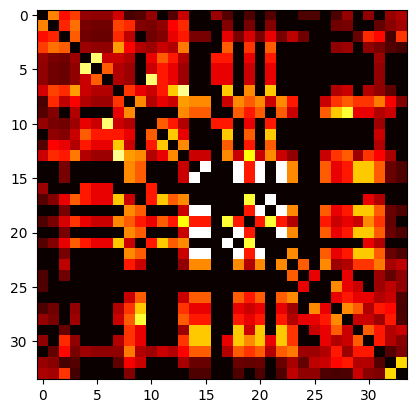

In [14]:
plt.imshow(np.array(sorenson_matrix), cmap='hot')
plt.show()

In [15]:
salton_matrix = salton(graph)

salton_matrix

array([[0.        , 1.16666667, 0.79056942, ..., 0.        , 0.4330127 ,
        0.48507125],
       [1.16666667, 0.        , 0.84327404, ..., 0.27216553, 0.38490018,
        0.48507125],
       [0.79056942, 0.84327404, 0.        , ..., 0.77459667, 0.18257419,
        0.92035799],
       ...,
       [0.        , 0.27216553, 0.77459667, ..., 0.        , 0.23570226,
        0.39605902],
       [0.4330127 , 0.38490018, 0.18257419, ..., 0.23570226, 0.        ,
        1.40028008],
       [0.48507125, 0.48507125, 0.92035799, ..., 0.39605902, 1.40028008,
        0.        ]], shape=(34, 34))

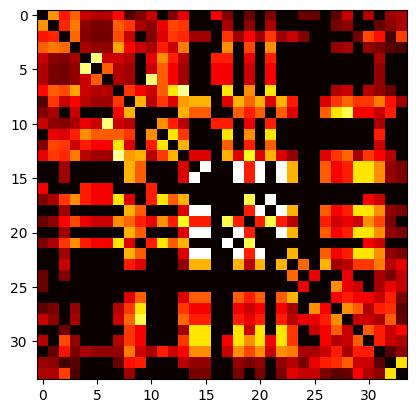

In [16]:
plt.imshow(np.array(salton_matrix), cmap='hot')
plt.show()

In [17]:
jaccard_matrix = jaccard(graph)

jaccard_matrix

array([[0.        , 0.38888889, 0.23809524, ..., 0.        , 0.12      ,
        0.13793103],
       [0.38888889, 0.        , 0.26666667, ..., 0.07142857, 0.10526316,
        0.13043478],
       [0.23809524, 0.26666667, 0.        , ..., 0.23076923, 0.04761905,
        0.28571429],
       ...,
       [0.        , 0.07142857, 0.23076923, ..., 0.        , 0.05882353,
        0.0952381 ],
       [0.12      , 0.10526316, 0.04761905, ..., 0.05882353, 0.        ,
        0.52631579],
       [0.13793103, 0.13043478, 0.28571429, ..., 0.0952381 , 0.52631579,
        0.        ]], shape=(34, 34))

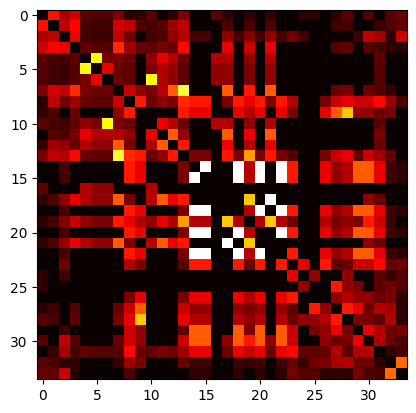

In [18]:
plt.imshow(np.array(jaccard_matrix), cmap='hot')
plt.show()

## Laplacians

In [19]:
L = get_laplacian(graph)

L

array([[16., -1., -1., ..., -1.,  0.,  0.],
       [-1.,  9., -1., ...,  0.,  0.,  0.],
       [-1., -1., 10., ...,  0., -1.,  0.],
       ...,
       [-1.,  0.,  0., ...,  6., -1., -1.],
       [ 0.,  0., -1., ..., -1., 12., -1.],
       [ 0.,  0.,  0., ..., -1., -1., 17.]], shape=(34, 34))

In [20]:
np.sum(L, axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Eigenvalues and eigenvectors for adjacency matrix and L

In [21]:
A = get_matrix(graph)

A_eig_result = np.linalg.eigh(A)

A_eig_result

EighResult(eigenvalues=array([-4.48722919e+00, -3.44793486e+00, -3.11069092e+00, -2.43742443e+00,
       -2.09082295e+00, -2.00000000e+00, -1.68768945e+00, -1.44407374e+00,
       -1.19242425e+00, -1.04208785e+00, -7.92406815e-01, -4.18818748e-01,
       -1.21742840e-15, -9.92316874e-16, -7.60266907e-16, -3.93673784e-16,
       -2.63837154e-16,  3.91188050e-17,  4.40001575e-16,  6.43778172e-16,
        7.01131309e-16,  1.26697474e-15,  2.99410685e-01,  4.19729474e-01,
        6.15840589e-01,  8.34304102e-01,  1.03145042e+00,  1.08328639e+00,
        1.45305566e+00,  1.48615954e+00,  2.30908767e+00,  2.91650670e+00,
        4.97707423e+00,  6.72569773e+00]), eigenvectors=array([[ 0.31716992, -0.27730159,  0.55468453, ...,  0.19785758,
        -0.38686107,  0.35549144],
       [ 0.12496128, -0.10787731,  0.01703733, ..., -0.25029731,
        -0.26893952,  0.26595992],
       [ 0.02726159,  0.53924221,  0.13327895, ..., -0.2466749 ,
        -0.13115956,  0.3171925 ],
       ...,
       [-

In [22]:
L_eig_result = np.linalg.eigh(L)

L_eig_result

EighResult(eigenvalues=array([1.08853800e-15, 4.68525227e-01, 9.09247664e-01, 1.12501072e+00,
       1.25940411e+00, 1.59928308e+00, 1.76189862e+00, 1.82605521e+00,
       1.95505045e+00, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00,
       2.00000000e+00, 2.00000000e+00, 2.48709173e+00, 2.74915718e+00,
       3.01396297e+00, 3.24206748e+00, 3.37615409e+00, 3.38196601e+00,
       3.47218740e+00, 4.27587682e+00, 4.48000767e+00, 4.58079267e+00,
       5.37859508e+00, 5.61803399e+00, 6.33159222e+00, 6.51554463e+00,
       6.99619703e+00, 9.77724095e+00, 1.09210675e+01, 1.33061223e+01,
       1.70551712e+01, 1.81366960e+01]), eigenvectors=array([[ 0.17149859, -0.11213743,  0.06940423, ...,  0.09478253,
        -0.94093217,  0.19374903],
       [ 0.17149859, -0.04128789,  0.09514749, ..., -0.09918451,
         0.06586476,  0.00522422],
       [ 0.17149859,  0.02321896,  0.04270411, ...,  0.31479791,
         0.11506912,  0.02918609],
       ...,
       [ 0.17149859,  0.09875343, -0.028302

In [23]:
np.abs(L_eig_result.eigenvalues) < 1e-10

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

## Normalized laplacians

In [24]:
L_sym = get_sym_laplacian(graph)

In [25]:
L_sym_eig_result = np.linalg.eigh(L_sym)

L_sym_eig_result

EighResult(eigenvalues=array([-3.55242235e-16,  1.32272329e-01,  2.87048985e-01,  3.87313233e-01,
        6.12230540e-01,  6.48992947e-01,  7.07208202e-01,  7.39957989e-01,
        7.70910617e-01,  8.22942852e-01,  8.64832945e-01,  9.06816002e-01,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.10538084e+00,  1.15929996e+00,
        1.26802355e+00,  1.35177826e+00,  1.39310454e+00,  1.41691585e+00,
        1.44857938e+00,  1.49703011e+00,  1.56950660e+00,  1.58333333e+00,
        1.61190959e+00,  1.71461135e+00]), eigenvectors=array([[-3.20256308e-01,  2.96399797e-01, -1.44586983e-01, ...,
        -5.13266212e-15,  1.92425279e-02, -2.21118943e-01],
       [-2.40192231e-01,  1.13413889e-01, -3.50466912e-01, ...,
        -4.29457724e-15,  3.02953464e-02, -1.85412174e-01],
       [-2.53184842e-01, -8.97112612e-03, -2.11481660e-01, ...,
         

In [26]:
L_rw = get_rw_laplacian(graph)

L_rw

array([[ 1.        , -0.0625    , -0.0625    , ..., -0.0625    ,
         0.        ,  0.        ],
       [-0.11111111,  1.        , -0.11111111, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1       , -0.1       ,  1.        , ...,  0.        ,
        -0.1       ,  0.        ],
       ...,
       [-0.16666667,  0.        ,  0.        , ...,  1.        ,
        -0.16666667, -0.16666667],
       [ 0.        ,  0.        , -0.08333333, ..., -0.08333333,
         1.        , -0.08333333],
       [ 0.        ,  0.        ,  0.        , ..., -0.05882353,
        -0.05882353,  1.        ]], shape=(34, 34))

In [27]:
L_rw_eig_result = np.linalg.eig(L_rw)

L_rw_eig_result

EigResult(eigenvalues=array([2.77555756e-16, 1.32272329e-01, 2.87048985e-01, 3.87313233e-01,
       1.71461135e+00, 6.12230540e-01, 6.48992947e-01, 7.07208202e-01,
       7.39957989e-01, 7.70910617e-01, 8.22942852e-01, 8.64832945e-01,
       9.06816002e-01, 1.10538084e+00, 1.15929996e+00, 1.26802355e+00,
       1.61190959e+00, 1.56950660e+00, 1.35177826e+00, 1.39310454e+00,
       1.41691585e+00, 1.44857938e+00, 1.49703011e+00, 1.58333333e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00]), eigenvectors=array([[ 1.71498585e-01, -1.42326767e-01, -6.99275507e-02, ...,
        -1.98487935e-17,  3.16941661e-16, -1.57904880e-16],
       [ 1.71498585e-01, -7.26128803e-02, -2.25998148e-01, ...,
         1.57104084e-16, -2.63193242e-16, -3.02474967e-17],
       [ 1.71498585e-01,  5.44898531e-03, -1.29375435e-01, ...,
         2.70271532e-17,  5.66856850e-16, -3